In [53]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter 
from skimage.morphology import remove_small_objects, closing, square


In [34]:

# Step 1: Read the Raster Image
raster_path = r"C:\Users\TyHow\MinersAI Dropbox\Product\Pilot Projects\Chile - Mantos Grandes\Geology\archivo_geologia-de-los-cuadrangulos-d-86-las-ramadas-carrizal-y-paso-rio-negro-region-de-coquimbo\MAP1\Georeferencing\Finalized_Items\MAP1_GR_FINAL.tif"  # Replace with your raster file path

with rasterio.open(raster_path) as src:
    # Read all bands into a 3D NumPy array (bands, rows, columns)
    raster_data = src.read()
    # Convert to float to handle NaNs
    raster_data = raster_data.astype('float32')  # Convert to float to allow NaN values
    # Get metadata
    transform = src.transform
    crs = src.crs


In [35]:

# Step 2: Prepare the Data for Clustering
# Reshape the raster data to a 2D array where each pixel is a row
# If the raster has multiple bands, we preserve them for clustering

# Define a threshold to identify black pixels
black_threshold = 10  # Adjust this value as needed for your specific image

# Create a mask for black pixels
if raster_data.shape[0] > 1:  # Multi-band (e.g., RGB) image
    black_mask = np.all(raster_data <= black_threshold, axis=0)
else:  # Single-band image
    black_mask = raster_data[0] <= black_threshold\

# Set black pixels to NaN
raster_data[:, black_mask] = -1


n_bands, n_rows, n_cols = raster_data.shape
reshaped_data = raster_data.reshape((n_bands, n_rows * n_cols)).T


In [49]:

# Step 3: Run K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=31)
kmeans.fit(reshaped_data)

# Get the cluster labels for each pixel
clustered = kmeans.labels_


In [50]:

# Step 4: Reshape the clustered result back to the original raster shape
clustered_image = clustered.reshape((n_rows, n_cols))


In [64]:
# Step 7: Convert NaNs to Zero for Morphological Operations
smoothed_image_cleaned = np.nan_to_num(clustered_image, nan=0)

# Step 8: Apply Morphological Closing to Connect Grid Lines
# Use a square structuring element to help close the gaps
closed_image = closing(smoothed_image_cleaned, square(10))  # Use square(6) to connect gaps up to 6 pixels wide

# Step 9: Remove Small Objects
# Convert to integer type for remove_small_objects
closed_image = closed_image.astype(int)

# Use remove_small_objects to filter out elements smaller than a larger threshold
filtered_image = remove_small_objects(closed_image, min_size=30)  # Adjust min_size as ne

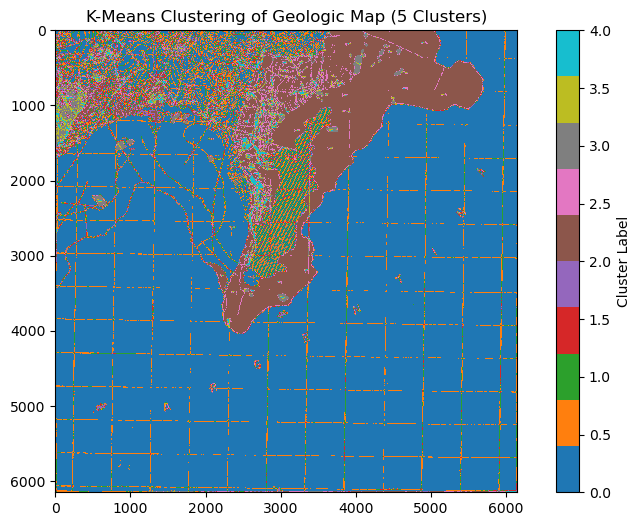

In [65]:

# Step 5: Visualize the Clustering Result
plt.figure(figsize=(10, 6))
plt.imshow(filtered_image, cmap='tab10')
plt.title('K-Means Clustering of Geologic Map (5 Clusters)')
plt.colorbar(label='Cluster Label')
plt.show()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
import rasterio
import numpy as np
import os  

raster_map = r"C:\Users\TyHow\Documents\3. Work\GIS Stuff\SCP testing\calingasta_best_output.tif"

# read geotiffs
data, names = [], []  # Lists to store data and corresponding file names

with rasterio.open(raster_map, 'r') as src:  # Open GeoTIFF file for reading
    # read spatial information
    transform = src.transform  # Get affine transformation matrix
    region = (src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3])  # Get bounding box coordinates (left, bottom, right, top)
    # read band 1 data
    d = src.read(1).astype('float32')  # Read data from the first band and convert to float32
    nodata_mask = d == src.nodata  # Create a mask for NoData values
    d[nodata_mask] = np.nan  # Replace NoData values with NaN
    # append data to lists
    data.append(d)  # Append data to the list
    names.append(os.path.basename(raster_map).replace('.tif',''))  # Append file name to the list (without extension)

# stack list into 3D numpy array
data = np.stack(data)  # Stack the list of arrays into a 3D numpy array
data.shape, names  # Return the shape of the data array and the list of file names


((1, 5604, 3497), ['calingasta_best_output'])

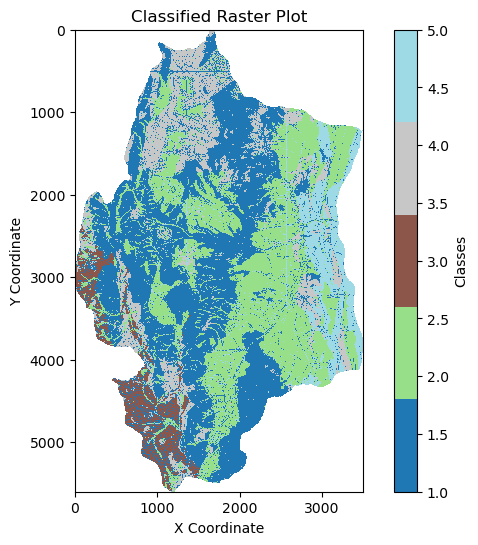

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



# Plot the raster array
plt.figure(figsize=(8, 6))

# Create a colormap with unique colors for each unique class
cmap = plt.get_cmap('tab20', len(np.unique(data[0][~np.isnan(data[0])])))

# Plot the data
plt.imshow(data[0], cmap=cmap, interpolation='nearest')
plt.colorbar(label='Classes')  # Show a color bar with class labels
plt.title('Classified Raster Plot')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

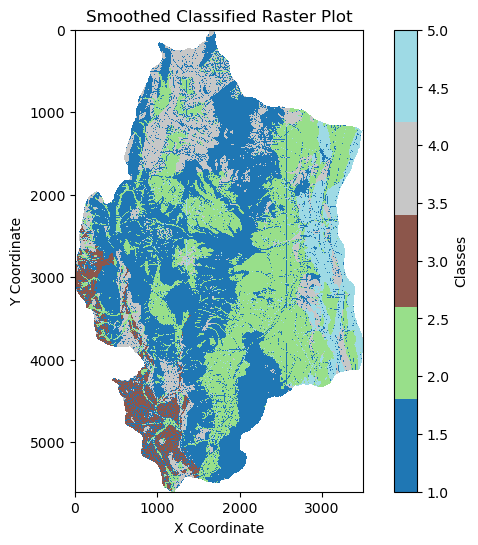

In [9]:
#SCIPY MAJORITY FILTER
from scipy.ndimage import generic_filter

# Function to apply the majority filter
def majority_filter(data, size=3):
    """
    Applies a majority filter to reduce noise in classified raster data.

    Parameters:
    - data: 2D numpy array of raster data
    - size: Size of the moving window (3 means 3x3 window, 5 means 5x5, etc.)

    Returns:
    - Filtered 2D numpy array with reduced noise
    """
    def mode(array):
        """Finds the most frequent value in the array."""
        values, counts = np.unique(array, return_counts=True)
        return values[np.argmax(counts)]

    # Apply the majority filter using the scipy generic_filter
    return generic_filter(data, mode, size=(size, size))


# Apply majority filter to the data
filtered_data = majority_filter(data[0], size=3)

# Plot the filtered raster array
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap('tab20', len(np.unique(filtered_data[~np.isnan(filtered_data)])))

plt.imshow(filtered_data, cmap=cmap, interpolation='nearest')
plt.colorbar(label='Classes')
plt.title('Smoothed Classified Raster Plot')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [3]:
#CUPY MAJORITY FILTER
import cupy as cp

# Function to apply the majority filter using CuPy
def majority_filter_gpu(data, size=3):
    """
    Applies a majority filter to reduce noise in classified raster data using GPU.

    Parameters:
    - data: 2D cupy array of raster data
    - size: Size of the moving window (3 means 3x3 window, 5 means 5x5, etc.)

    Returns:
    - Filtered 2D cupy array with reduced noise
    """
    # Pad data for edge handling
    padded_data = cp.pad(data, pad_width=size//2, mode='reflect')
    filtered_data = cp.zeros_like(data)

    # Apply the majority filter using sliding window
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            window = padded_data[i:i+size, j:j+size]
            values, counts = cp.unique(window, return_counts=True)
            filtered_data[i, j] = values[cp.argmax(counts)]

    return filtered_data


# Convert data to CuPy array for GPU processing
data = cp.array(data[0])

# Apply majority filter to the data using GPU
filtered_data = majority_filter_gpu(data, size=3)

# Convert the filtered data back to NumPy array for plotting
filtered_data_np = cp.asnumpy(filtered_data)

# Plot the filtered raster array
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap('tab20', len(np.unique(filtered_data_np[~np.isnan(filtered_data_np)])))

plt.imshow(filtered_data_np, cmap=cmap, interpolation='nearest')
plt.colorbar(label='Classes')
plt.title('Smoothed Classified Raster Plot (GPU-Accelerated)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

KeyboardInterrupt: 

In [6]:
#SCIPY MODE FILTER
from scipy.ndimage import generic_filter
from scipy.stats import mode

# Function to apply mode filter
def mode_filter(data):
    return mode(data, axis=None)[0]

# Apply mode filter with a 5x5 window
smoothed_array = generic_filter(data, mode_filter, size=5)

# Plot the filtered raster array
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap('tab20', len(np.unique(smoothed_array[~np.isnan(smoothed_array)])))

plt.imshow(smoothed_array, cmap=cmap, interpolation='nearest')
plt.colorbar(label='Classes')
plt.title('Smoothed Classified Raster Plot')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002AC9A4930B0>>
Traceback (most recent call last):
  File "C:\Users\TyHow\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\TyHow\anaconda3\envs\conda_env\Lib\threading.py", line 1543, in enumerate
    with _active_limbo_lock:
SystemError: <built-in method __enter__ of _thread.RLock object at 0x000002AC96317180> returned a result with an exception set


In [ ]:
#CUPY MODE FILTER
import cupy as cp
import matplotlib.pyplot as plt
from scipy.stats import mode

# Assume `data` is your raster array loaded as a CuPy array
# Convert data from NumPy to CuPy array if necessary
data = cp.array(your_data)  # Replace your_data with your raster data

# Function to compute mode along the flattened axis
def mode_filter_2d(array, window_size):
    pad_width = window_size // 2
    # Pad the array to handle borders
    padded_array = cp.pad(array, pad_width=pad_width, mode='constant', constant_values=cp.nan)
    
    # Initialize the result array
    result = cp.empty_like(array)

    # Apply the mode filter
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            # Extract the local window
            window = padded_array[i:i + window_size, j:j + window_size].flatten()
            # Compute the mode using SciPy mode function (on the CPU)
            result[i, j] = mode(cp.asnumpy(window), axis=None, nan_policy='omit')[0]

    return result

# Apply the mode filter
window_size = 5
smoothed_array = mode_filter_2d(data, window_size)

